### Intro

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL.Image import open
from IPython import display
from time import time

import os
from glob import glob
from Img2Graph import *
from main import *

In [2]:
def segment_plot(G, img, img_seed, s=2):
    # initialize: S = {s}, T = {t}, A = {s, t}, O = ∅
    A = ['S','T']
    i = 0
    t = time()
    while True:
        if time() - t > s or i == 0:
            plt.figure(figsize=(15,7))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            plt.subplot(131)
            plt.imshow(img, cmap='gray')
            plt.subplot(132)
            plt.imshow(graph2img(G, *img.shape), cmap='seismic')
            plt.subplot(133)
            plt.imshow(img_seed, cmap='gray')
            plt.show()
            t = time()
            i = 1
        # grow S or T to find an augmenting path P from s to t
        P = grow(G, A)
        # if P = ∅ terminate
        if not P:
            break
        # augment on P
        Orphans = augment(G, P)
        # adopt orphans
        A = adopt(G, Orphans, A)
    
    plt.figure(figsize=(15,7))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.subplot(132)
    plt.imshow(graph2img(G, *img.shape), cmap='seismic')
    plt.subplot(133)
    plt.imshow(img_seed, cmap='gray')
    plt.show()

    # end while
    return G


### Dog test

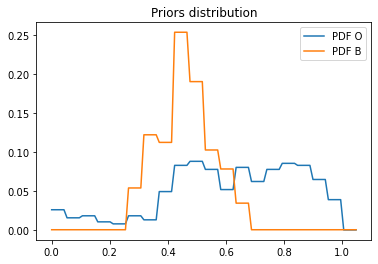

In [15]:
W, H = 50,50
img = np.array(open('images/dog_small.jpg').convert('L').resize((W, H))) / 255
img_painted = np.array(open('images/dog_small_ST.jpg').convert('RGB').resize((W, H)))

priors = initialize_priors(img_painted)
nbins = 20
G, probs = image2graph(img, *priors, nbins=nbins, prior_as_index=True)

X = np.linspace(0, 1 + 1/(nbins+1), 100)
plt.title("Priors distribution")
plt.plot(X, probs["obj"](X), label='PDF O')
plt.plot(X, probs["bkg"](X), label='PDF B')
plt.legend()
plt.show()

<Figure size 1080x504 with 0 Axes>

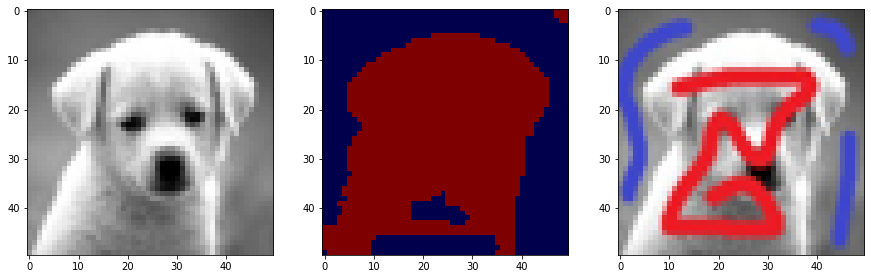

In [16]:
segment_plot(G, img, img_painted, s=1)

### Experiment data

In [3]:
images = [open(path).convert('L') for path in glob(os.path.join("dataset",'images',"*.jpg"))]
groundtruths = [open(path).convert('L') for path in glob(os.path.join("dataset",'images-gt',"*.png"))]
labels = [open(path) for path in glob(os.path.join("dataset",'images-labels',"*.png"))]

In [6]:
img = np.array(images[0]) / 255
gt = np.array(groundtruths[0])
label = np.array(labels[0])

priors = (label==1, label==2)
nbins = 20
G, probs = image2graph(img, *priors, nbins=nbins, prior_as_mask=True)

X = np.linspace(0, 1 + 1/(nbins+1), 100)
plt.title("Priors distribution")
plt.plot(X, probs["obj"](X), label='PDF O')
plt.plot(X, probs["bkg"](X), label='PDF B')
plt.legend()
plt.show()

IndexError: too many indices for array